In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import preprocessing

Vamos a utilizar para este notebook los mismos datos usados para clasificación en la clase pasada.

In [73]:
data_path = 'https://raw.githubusercontent.com/yarrap/Penguin-Species-Prediction/refs/heads/main/penguins_size.csv'

In [74]:
df = pd.read_csv(data_path);
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Ignoraremos la columna "especie" ya que supondremos que no conocemos la especie de pingüino a priori.
Además, intentaremos ver si podemos armar grupos de pingüinos solo considerando sus características físicas, por lo que ignoraremos la isla donde fueron censados, y el sexo

(Ignorar la isla puede ser un error a priori, ya que sabemos que es un predictor importante para una de las especies. No obstante, esto no lo sabríamos sin hacer un estudio más profundo.)

In [75]:
df_prep = df.copy()
# Eliminamos primero datos perdidos
df_prep = df.dropna()
# Eliminamos la columna specie
species = df_prep.pop('species')
# Eliminamos la isla
island = df_prep.pop('island')
# Eliminamos el sexo
sex = df_prep.pop('sex')

df_prep.head()


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


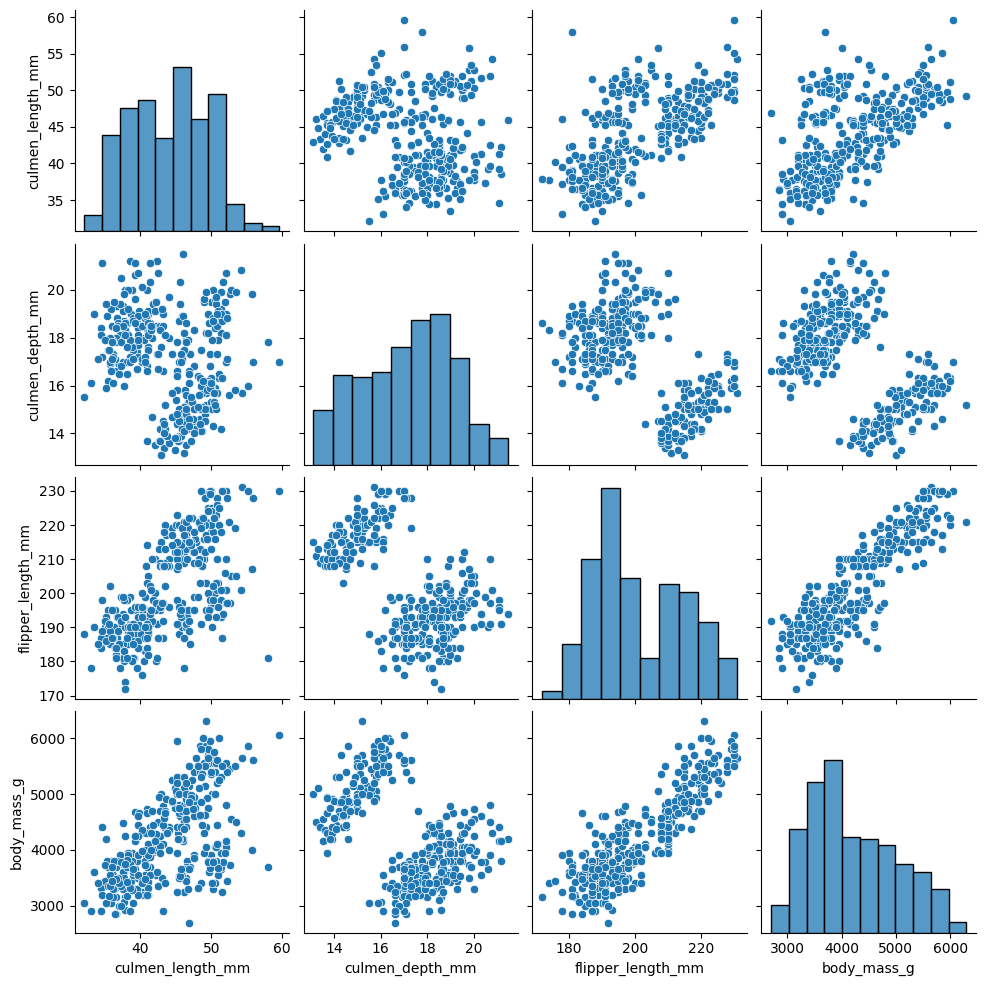

In [76]:
sns.pairplot(df_prep)

Podemos observar entre dos y tres grupos en los datos. Por tanto, intentaremos encontrarlos haciendo uso de K-MEANS

# K-means

Con K-means, agruparemos los pinguinos según su similitud, utilizando como medida de similitud la distancia euclidiana. 

Como resultado del agrupamiento, tendremos una nueva columna que nos indica a que grupo pertenece cada ejemplo de la tabla.

In [77]:
from sklearn.cluster import KMeans

In [78]:
# Instanciamos el modelo con los parámetros que nos interesan
model = KMeans(**{
      'init':"random", # Forma de inicializar los centroides
      'n_clusters':3, # Cantidad de centroides y, por lo tanto, de grupos
      'max_iter':300 # Cantidad máxima de iteraciones si no converge antes.
})

In [79]:
# Entrenamos el modelo, esto es, determinar la posición de los centroides.
model.fit(df_prep)

,n_clusters,3
,init,'random'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


Una vez entrenados los datos, podemos ver a que grupo pertenece cada pingüino.

In [80]:
predicted_groups = df_prep.copy()
predicted_groups['cluster'] = model.predict(df_prep)
predicted_groups.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,cluster
0,39.1,18.7,181.0,3750.0,2
1,39.5,17.4,186.0,3800.0,2
2,40.3,18.0,195.0,3250.0,2
4,36.7,19.3,193.0,3450.0,2
5,39.3,20.6,190.0,3650.0,2


Veamos cómo se realizó el agrupamiento:

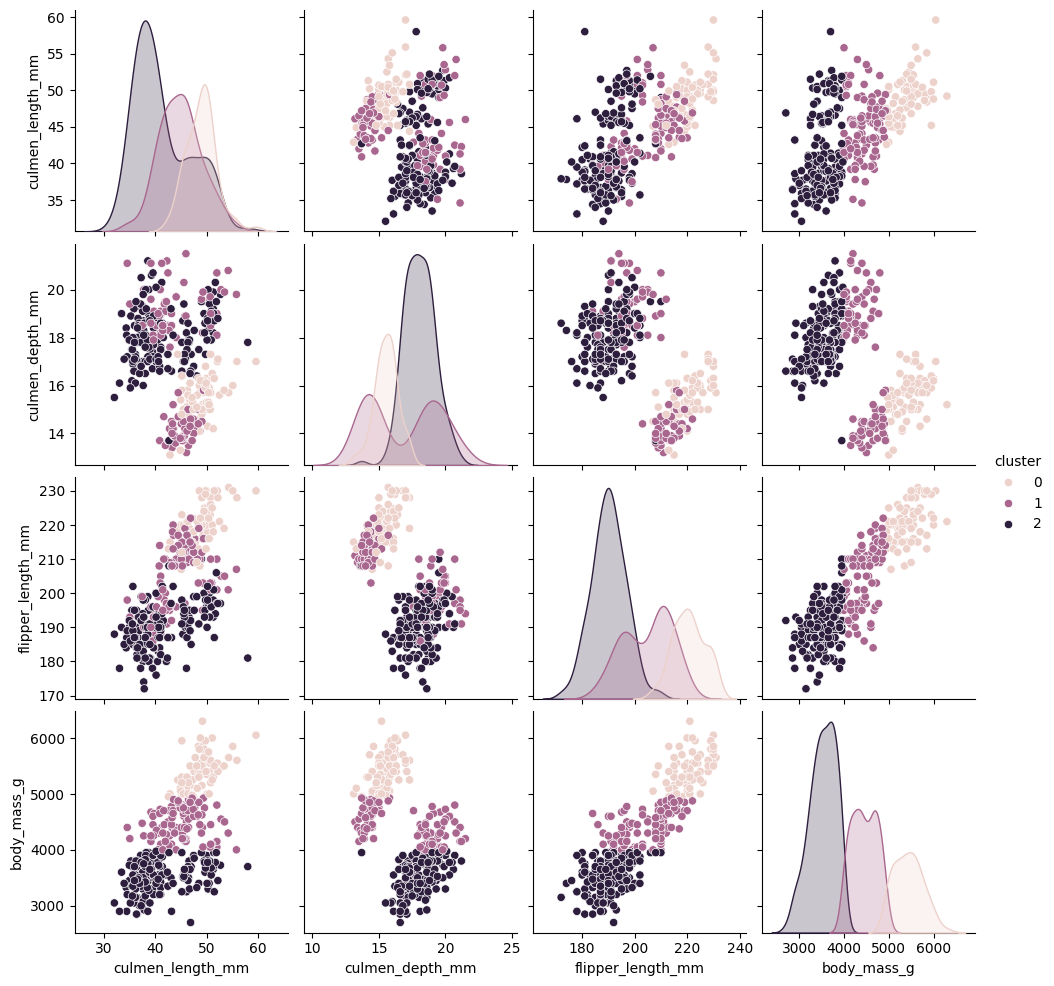

In [81]:
sns.pairplot(predicted_groups, hue='cluster')

Podemos ver en el pairplot, que el atributo body_mass_g es el principal que se toma para realizar el agrupamiento. ¿Por qué? Porque su magnitud es mas grande que el resto...esto es...pequeñas diferencias en el body_mass_g impactan de forma grande en la función de distancia. 

Por esto, resulta necesario escalar todos los valores al mismo intervalo, así todos pesan lo mismo.

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [83]:
df_prep_scaled = df_prep.copy()

scaler = MinMaxScaler()
df_prep_scaled = pd.DataFrame(
    scaler.fit_transform(df_prep_scaled.values),
    columns=df_prep_scaled.columns, 
    index=df_prep_scaled.index
)


df_prep_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0.254545,0.666667,0.152542,0.291667
1,0.269091,0.511905,0.237288,0.305556
2,0.298182,0.583333,0.389831,0.152778
4,0.167273,0.738095,0.355932,0.208333
5,0.261818,0.892857,0.305085,0.263889


In [84]:
# Volvemos a entrenar ahora con este conjunto de datos

model = KMeans(** {
      'init':"random",
      'n_clusters':3,
      'max_iter':300,
})
predicted_2 = df_prep_scaled.copy()
predicted_2['cluster'] = model.fit_predict(df_prep_scaled)
predicted_2.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,cluster
0,0.254545,0.666667,0.152542,0.291667,2
1,0.269091,0.511905,0.237288,0.305556,2
2,0.298182,0.583333,0.389831,0.152778,2
4,0.167273,0.738095,0.355932,0.208333,2
5,0.261818,0.892857,0.305085,0.263889,2


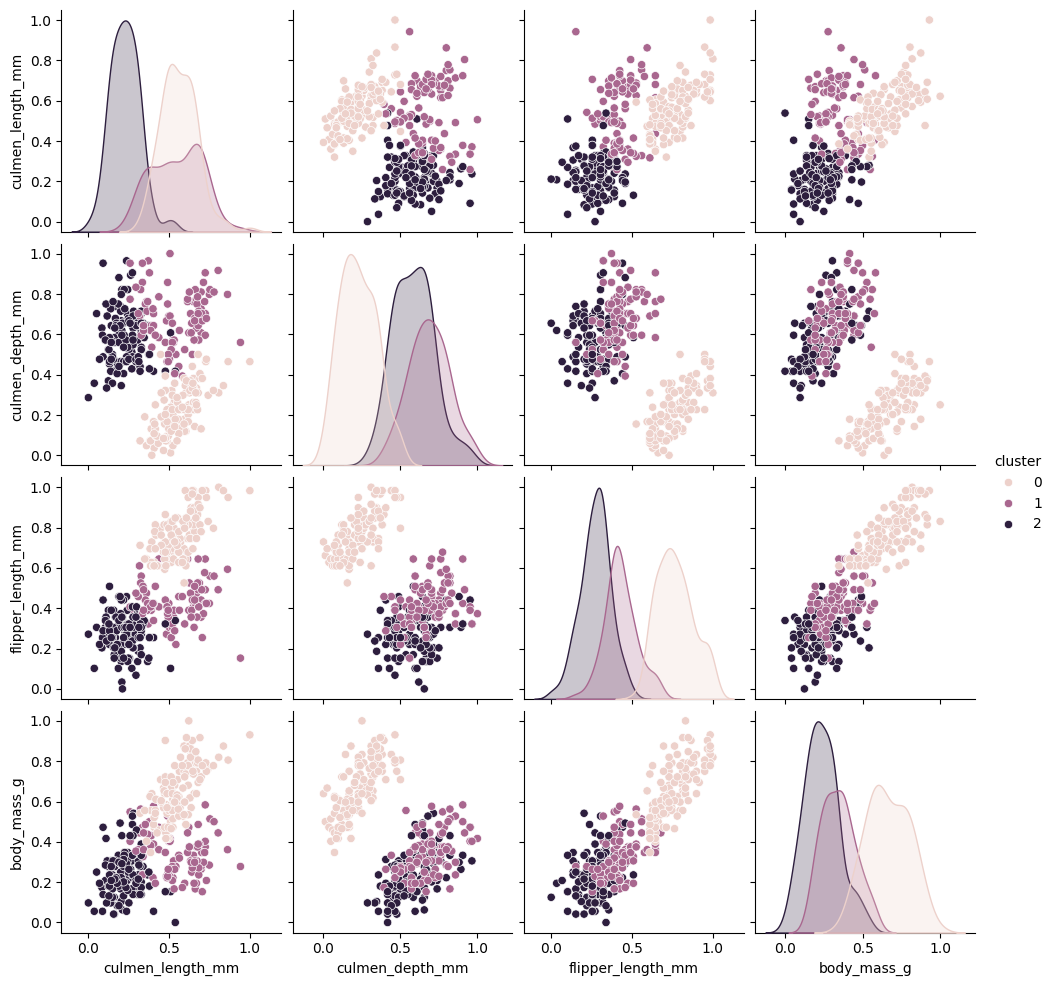

In [85]:
sns.pairplot(predicted_2, hue='cluster')

Ahora podemos ver que el método detecta mejor a uno de los grupos...

¿Cómo hacemos para ver cuales son las características de cada grupo encontrado? 

Podemos ver los centroides para eso...pero primero, cómo los atributos fueron todos transformados, debemos recuperar los datos originales.

In [86]:
pd.DataFrame(scaler.inverse_transform(model.cluster_centers_), columns=df_prep.columns)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,47.542500,15.002500,217.233333,5090.625000
1,47.151685,18.866292,197.280899,3940.168539
2,38.340000,18.017600,188.104000,3554.200000


Ahora podemos saber cuales son las características promedio de cada grupo de pingüinos.

No obstante, esto es un poco dificil de interpretar, por lo que usaremos árboles de decisión para poder determinar a que grupo pertenece cada pingüino en función de sus atributos:

In [87]:
# Primero, asignaremos la columna cluster a los datos originales. 

df_predicted_without_transformation = df_prep.copy()

df_predicted_without_transformation['cluster'] = predicted_2['cluster']
df_predicted_without_transformation.head()


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,cluster
0,39.1,18.7,181.0,3750.0,2
1,39.5,17.4,186.0,3800.0,2
2,40.3,18.0,195.0,3250.0,2
4,36.7,19.3,193.0,3450.0,2
5,39.3,20.6,190.0,3650.0,2


In [88]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report # Evaluación de los datos

In [89]:
y = df_predicted_without_transformation.pop('cluster')
X = df_predicted_without_transformation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

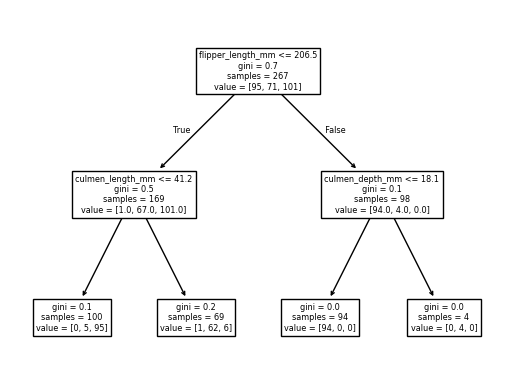

In [90]:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train, y_train)

_ = plot_tree(tree_model,
                   feature_names=df_predicted_without_transformation.columns,
                   filled=False,
                   precision=1)

# Actividades

1. Utilizar métricas sobre los datos de testing para determinar que tan bueno es el arbol de clasificación (como hicimos en el notebook de clasificación).
2. Comparar los resultados obtenidos con los pingüinos que deberíamos obtener (están en la variable 'species' creada arriba). Hay alguna diferencia? ¿a que se puede deber?
3. ¿Qué es el criterio del codo (elbow method)? Investigar.